In [1]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2
from tqdm import tqdm
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models,Model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.utils import to_categorical
import seaborn as sns

In [2]:
IMG_SIZE = 64
Channel=3
Epochs=20
Batch_size=32
no_classes=12

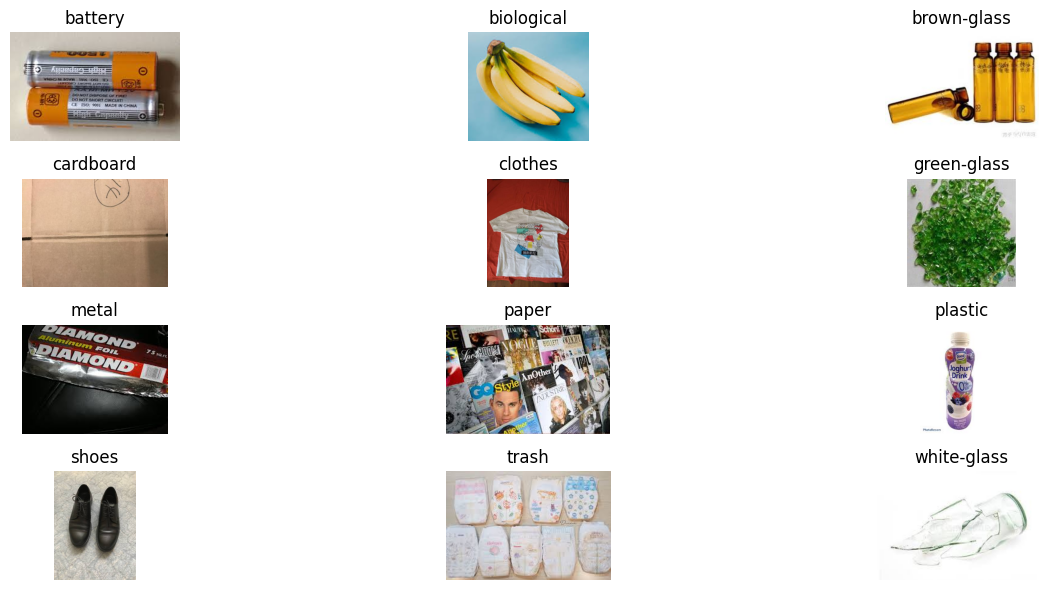

In [3]:
DATADIR = 'D:\garbage_classification'  
CATEGORIES = ["battery", "biological","brown-glass", "cardboard", "clothes", "green-glass",
              "metal", "paper", "plastic", "shoes", "trash","white-glass"]
fig, axes = plt.subplots(4, 3, figsize=(15, 6))
axes = axes.ravel()

for i, category in enumerate(CATEGORIES): 
    path = os.path.join(DATADIR, category)
    img = os.listdir(path)[0]  
    img_array = cv2.imread(os.path.join(path, img)) 
    img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)

    axes[i].imshow(img_array)
    axes[i].set_title(category)  
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [4]:
print(img_array)
print(img_array.shape)

[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]
(177, 285, 3)


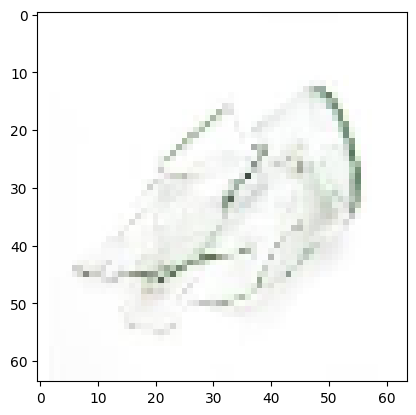

In [5]:
new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array)
plt.show()

In [6]:
training_data = []

def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)  
        class_num = CATEGORIES.index(category) 
        for img_name in tqdm(os.listdir(path), desc=f"Processing {category}"):  
            try:
                img_path = os.path.join(path, img_name)
                img_array = cv2.imread(img_path)  
                img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)  
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  
                training_data.append([new_array, class_num])  
            except Exception as e:
                print(f"Error processing image {img_name} in {category}: {e}")

create_training_data()
print(f"Total training samples: {len(training_data)}")

Processing white-glass: 100%|██████████| 775/775 [00:00<00:00, 778.07it/s]

Total training samples: 15515


In [7]:
random.shuffle(training_data)
for sample in training_data[:10]:
    print(sample[1])

4
11
9
4
9
4
4
4
0
3


In [8]:
X = []
y = []


for features, label in training_data:
    X.append(features)
    y.append(label)


X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE,Channel) 
X = X / 255
y = np.array(y)

In [9]:
print(X)
print(X.shape)

[[[[0.85098039 0.78431373 0.72156863]
   [0.86666667 0.8        0.7372549 ]
   [0.86666667 0.8        0.73333333]
   ...
   [0.83137255 0.76862745 0.70588235]
   [0.83921569 0.77647059 0.71372549]
   [0.83137255 0.76470588 0.70588235]]

  [[0.83921569 0.77254902 0.70980392]
   [0.86666667 0.8        0.7372549 ]
   [0.8745098  0.80784314 0.74117647]
   ...
   [0.80392157 0.74117647 0.67843137]
   [0.83921569 0.77647059 0.71372549]
   [0.83529412 0.77254902 0.70980392]]

  [[0.84313725 0.77647059 0.70588235]
   [0.8627451  0.79607843 0.7254902 ]
   [0.8627451  0.79215686 0.72156863]
   ...
   [0.84705882 0.78039216 0.72156863]
   [0.84705882 0.78039216 0.72156863]
   [0.83921569 0.77647059 0.71764706]]

  ...

  [[0.61960784 0.5372549  0.44313725]
   [0.64705882 0.56862745 0.4745098 ]
   [0.69019608 0.61960784 0.52941176]
   ...
   [0.78823529 0.71764706 0.65490196]
   [0.79607843 0.72941176 0.66666667]
   [0.77254902 0.70588235 0.63921569]]

  [[0.46666667 0.3372549  0.23921569]
   [0.5

In [10]:
def conv_block(input_tensor, filters, kernel_size=3, stride=2):
    
    # Unpack filter sizes
    filter1, filter2, filter3 = filters

    # Shortcut connection
    shortcut = layers.Conv2D(filter3, (1, 1), strides=stride, padding="valid")(input_tensor)
    shortcut = layers.BatchNormalization()(shortcut)

    # First convolution layer
    x = layers.Conv2D(filter1, (1, 1), strides=stride, padding="valid")(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Second convolution layer
    x = layers.Conv2D(filter2, kernel_size, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Third convolution layer
    x = layers.Conv2D(filter3, (1, 1), padding="valid")(x)
    x = layers.BatchNormalization()(x)

    # Add shortcut and apply ReLU
    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)

    return x


# Identity Block
def identity_block(input_tensor, filters, kernel_size=3):
    
    # Unpack filter sizes
    filter1, filter2, filter3 = filters

    # First convolution layer
    x = layers.Conv2D(filter1, (1, 1), padding="valid")(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Second convolution layer
    x = layers.Conv2D(filter2, kernel_size, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Third convolution layer
    x = layers.Conv2D(filter3, (1, 1), padding="valid")(x)
    x = layers.BatchNormalization()(x)

    # Add shortcut and apply ReLU
    x = layers.Add()([x, input_tensor])
    x = layers.ReLU()(x)

    return x


# ResNet-50 Model
def ResNet50(input_shape=(IMG_SIZE, IMG_SIZE, Channel), num_classes=no_classes):
    
    inputs = layers.Input(shape=input_shape)

    # Initial Conv Layer
    x = layers.ZeroPadding2D((3, 3))(inputs)
    x = layers.Conv2D(64, (7, 7), strides=2, padding="valid")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((3, 3), strides=2, padding="same")(x)

    # Stage 1
    x = conv_block(x, filters=(64, 64, 256), stride=1)
    x = identity_block(x, filters=(64, 64, 256))
    x = identity_block(x, filters=(64, 64, 256))

    # Stage 2
    x = conv_block(x, filters=(128, 128, 512))
    x = identity_block(x, filters=(128, 128, 512))
    x = identity_block(x, filters=(128, 128, 512))
    x = identity_block(x, filters=(128, 128, 512))

    # Stage 3
    x = conv_block(x, filters=(256, 256, 1024))
    x = identity_block(x, filters=(256, 256, 1024))
    x = identity_block(x, filters=(256, 256, 1024))
    x = identity_block(x, filters=(256, 256, 1024))
    x = identity_block(x, filters=(256, 256, 1024))
    x = identity_block(x, filters=(256, 256, 1024))

    # Stage 4
    x = conv_block(x, filters=(512, 512, 2048))
    x = identity_block(x, filters=(512, 512, 2048))
    x = identity_block(x, filters=(512, 512, 2048))

    # Final Layers
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Flatten()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    # Model
    model = Model(inputs, outputs)
    return model


# Instantiate the model
resnet50_model = ResNet50(input_shape=(IMG_SIZE, IMG_SIZE, Channel), num_classes=no_classes)

# Compile the model
resnet50_model.compile(optimizer="adam", 
                       loss="sparse_categorical_crossentropy", 
                       metrics=["accuracy"])

# Model Summary
resnet50_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)   0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   9472        ['zero_padding2d[0][0]']         
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                   

In [11]:
#base_model.summary()

In [12]:
'''
base_model=keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(64,64,3),
    pooling=None,
    classes=12,
    classifier_activation="softmax"
)
'''

'\nbase_model=keras.applications.ResNet50(\n    include_top=False,\n    weights="imagenet",\n    input_tensor=None,\n    input_shape=(64,64,3),\n    pooling=None,\n    classes=12,\n    classifier_activation="softmax"\n)\n'

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
history=resnet50_model.fit(X_train, y_train, epochs=20, batch_size=32,validation_split=0.1)

Epoch 1/20
350/350 [==============================] - 33s 58ms/step - loss: 2.0199 - accuracy: 0.4919 - val_loss: 2.5098 - val_accuracy: 0.4026
Epoch 2/20
350/350 [==============================] - 19s 54ms/step - loss: 1.4459 - accuracy: 0.5695 - val_loss: 2.2346 - val_accuracy: 0.4227
Epoch 3/20
350/350 [==============================] - 19s 54ms/step - loss: 1.3761 - accuracy: 0.5688 - val_loss: 1.3696 - val_accuracy: 0.5539
Epoch 4/20
350/350 [==============================] - 19s 54ms/step - loss: 1.0623 - accuracy: 0.6554 - val_loss: 1.1771 - val_accuracy: 0.6200
Epoch 5/20
350/350 [==============================] - 19s 54ms/step - loss: 1.0301 - accuracy: 0.6681 - val_loss: 1.0901 - val_accuracy: 0.6425
Epoch 6/20
350/350 [==============================] - 19s 53ms/step - loss: 1.0055 - accuracy: 0.6853 - val_loss: 1.3390 - val_accuracy: 0.5725
Epoch 7/20
350/350 [==============================] - 19s 53ms/step - loss: 0.9019 - accuracy: 0.7172 - val_loss: 3.3603 - val_accuracy:

In [15]:
test_loss, test_acc =resnet50_model.evaluate(X_test,y_test)
test_acc

97/97 [==============================] - 2s 16ms/step - loss: 0.9741 - accuracy: 0.7151


0.715114414691925

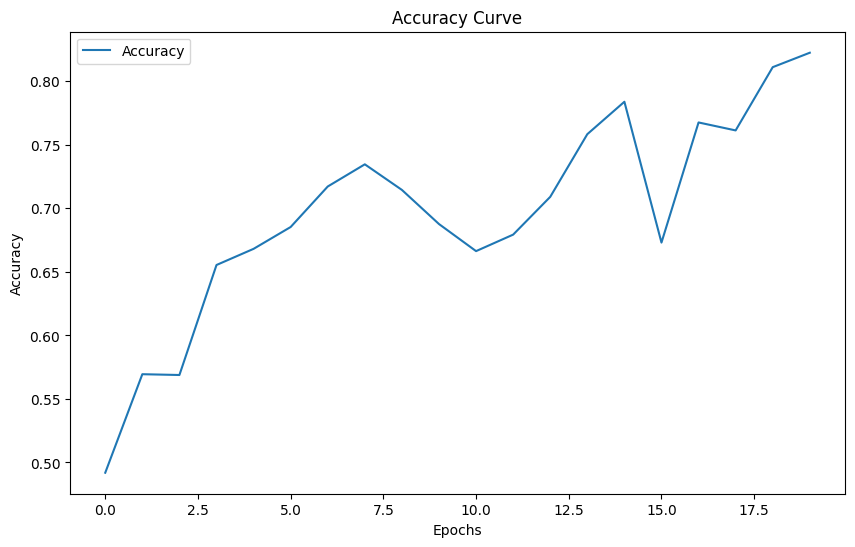

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.show()

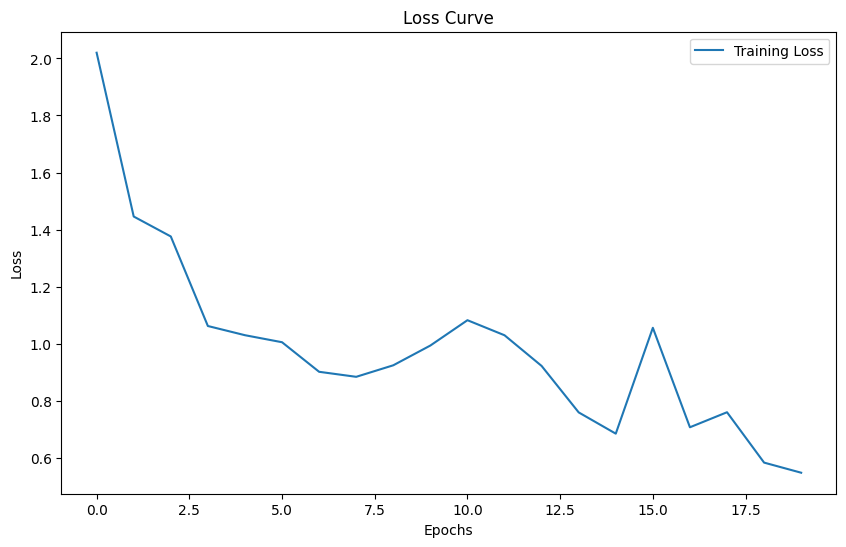

In [35]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

In [18]:
y_pred = resnet50_model.predict(X_test)

97/97 [==============================] - 2s 12ms/step


97/97 [==============================] - 1s 12ms/step


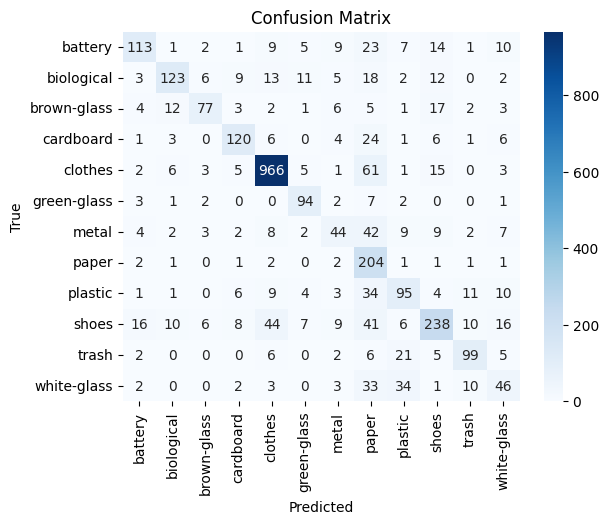

In [19]:
y_pred = np.argmax(resnet50_model.predict(X_test), axis=1)
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [20]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')  # 'macro' for multiclass
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=CATEGORIES))

# Display metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")


Classification Report:
              precision    recall  f1-score   support

     battery       0.74      0.58      0.65       195
  biological       0.77      0.60      0.68       204
 brown-glass       0.78      0.58      0.66       133
   cardboard       0.76      0.70      0.73       172
     clothes       0.90      0.90      0.90      1068
 green-glass       0.73      0.84      0.78       112
       metal       0.49      0.33      0.39       134
       paper       0.41      0.94      0.57       216
     plastic       0.53      0.53      0.53       178
       shoes       0.74      0.58      0.65       411
       trash       0.72      0.68      0.70       146
 white-glass       0.42      0.34      0.38       134

    accuracy                           0.72      3103
   macro avg       0.67      0.63      0.64      3103
weighted avg       0.74      0.72      0.72      3103

Accuracy: 0.72
Precision: 0.67
Recall: 0.63
F1-Score: 0.64


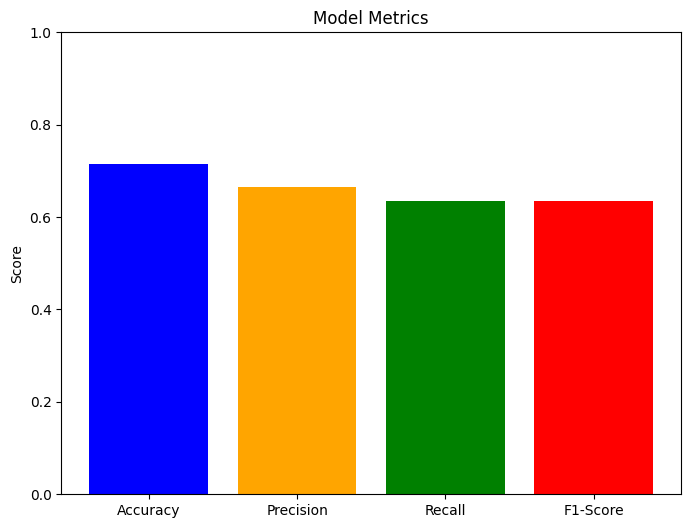

In [21]:
# Bar chart for metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [accuracy, precision, recall, f1]

plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color=['blue', 'orange', 'green', 'red'])
plt.ylim(0, 1)
plt.title('Model Metrics')
plt.ylabel('Score')
plt.show()

97/97 [==============================] - 1s 12ms/step


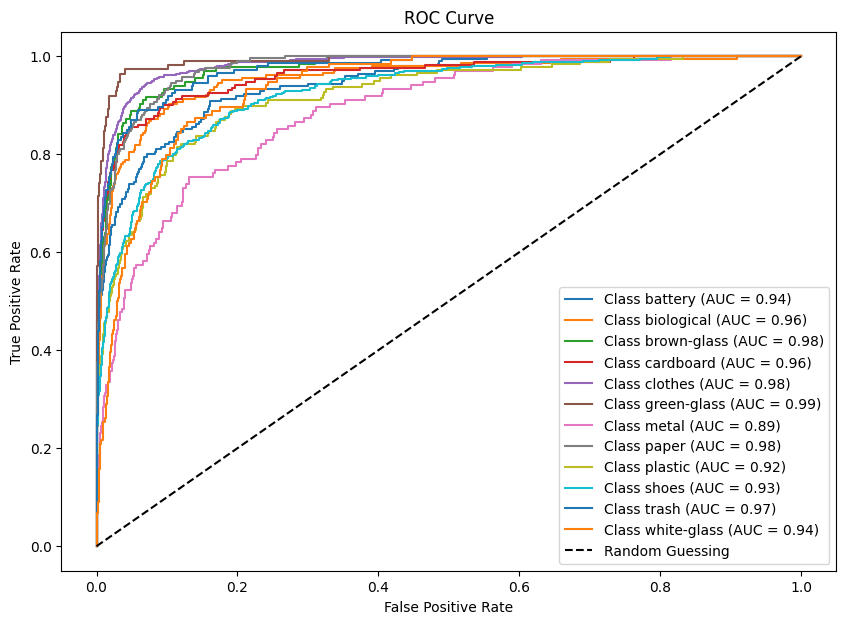

In [22]:
y_test_bin = to_categorical(y_test, num_classes=len(CATEGORIES))
y_pred_proba = resnet50_model.predict(X_test)  

plt.figure(figsize=(10, 7))
for i in range(len(CATEGORIES)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {CATEGORIES[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

97/97 [==============================] - 1s 12ms/step
Predicted category: trash
True category: trash


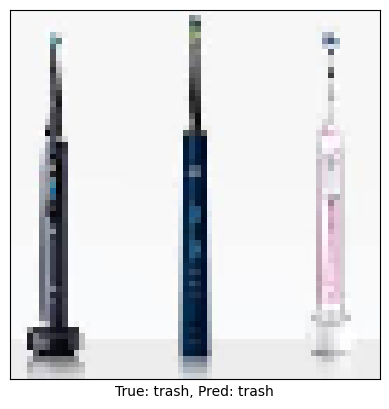

In [28]:
item =500  # The index of the image to display
predictions =resnet50_model.predict(X_test)  # Get predictions for x_test
predicted_label = np.argmax(predictions[item])  # Get the predicted class label (index)
true_label = y_test[item]  # Get the true label for the item (index)

# Convert the numerical indices to category names
predicted_category = CATEGORIES[predicted_label]
true_category = CATEGORIES[true_label]

# Print the predicted and true categories
print(f"Predicted category: {predicted_category}")
print(f"True category: {true_category}")

# Display the image
plt.imshow(X_test[item])  # Display the RGB image (no colormap needed)
plt.xticks([])  # Hide x-axis ticks
plt.yticks([])  # Hide y-axis ticks
plt.xlabel(f"True: {true_category}, Pred: {predicted_category}")  # Show category names
plt.show()

In [24]:
from tensorflow.keras.preprocessing import image
from pathlib import Path

def preprocess_image(image_path):
    try:
        # Load the image, resize to 32x32 and convert to RGB format
        img = image.load_img(image_path, target_size=(64, 64)) 
        # Convert the image to a numpy array and normalize it
        img_array = image.img_to_array(img) / 255 
        img_array = np.expand_dims(img_array, axis=0)
        return img_array
    except Exception as e:
        print(f"Error during preprocessing: {e}")
        return None

# Path to the external image (use pathlib for better path handling)
image_path = Path("D:\\Deep_project\\Test_Images\\Apple.jpg")

# Preprocess the external image
preprocessed_image = preprocess_image(image_path)

if preprocessed_image is not None:
    print("Image preprocessed successfully!")
else:
    print("Failed to preprocess the image.")


Image preprocessed successfully!


1/1 [==============================] - 0s 92ms/step


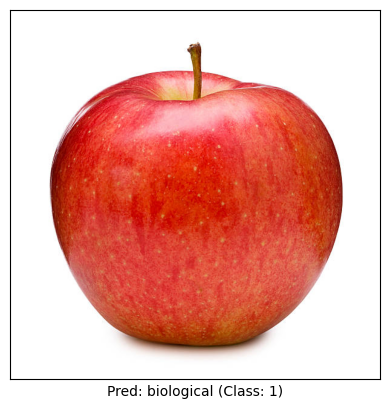

In [25]:
CATEGORIES = ["battery", "biological","brown-glass", "cardboard", "clothes", "green-glass",
              "metal", "paper", "plastic", "shoes", "trash","white-glass"]
# Get the prediction for the image
predictions =resnet50_model.predict(preprocessed_image)
predicted_label = np.argmax(predictions)  # Get the predicted class label (index)

# Display the image
img = image.load_img(image_path)  # Reload the image to show it
plt.imshow(img)  # Display the RGB image
plt.xticks([])  # Hide x-axis ticks
plt.yticks([])  # Hide y-axis ticks
plt.xlabel(f"Pred: {CATEGORIES[predicted_label]} (Class: {predicted_label})")
plt.show()


In [26]:
#resnet50_model.save("Resnet50.keras")